# Streaming Data Template

### -----


In [1]:
import requests;                                 # import package used to downlaod data from a web URL
import json;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
import matplotlib;

from pandas.io.json import json_normalize

matplotlib.style.use('ggplot');
%matplotlib inline

C:\Users\knispeja\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
with open('API Keys.txt', 'r') as keyfile:
    apiKeys=keyfile.read().split('\n')
   
url = 'http://backpack.tf/api/IGetPrices/v4/?key=' + apiKeys[0];        # web address of data stream

data_stream = requests.get(url,stream=True);                                    # create an iterable data stream object

rec = data_stream.iter_lines().next().strip() # Necessary before reading data
data = json.loads(rec)            # convert the json record to a python dictionary

In [3]:
def byteify(input):
    if isinstance(input, dict):
        return {byteify(key): byteify(value)
                for key, value in input.iteritems()}
    elif isinstance(input, list):
        return [byteify(element) for element in input]
    elif isinstance(input, unicode):
        return input.encode('utf-8')
    else:
        return input

data2 = byteify(data)

In [4]:
#Testing box. Useful/helps me remember. Do not remove.

#dfName = json_normalize(data2['response']['items']["Dillinger's Duffel"]['prices']['6']['Tradable']['Craftable']['0'])#['currency', 'difference', 'value', 'last_update'])
# if(dfName[0][0] == 'prices'):
#     print('Hello')
# dfName = json_normalize(data2['response']['items']["Dillinger's Duffel"], 'prices')
# for qualInt in dfName[0]:
#     dfTrade = json_normalize(data2['response']['items'][itemName]['prices'], qualInt)
#dfName

In [5]:
df = json_normalize(data2['response'])

In [6]:
#Just info that the website gives us.

raw_usd_value = df['raw_usd_value']
current_time = df['current_time']
success = df['success']
usd_currency_index = df['usd_currency_index']
usd_currency = df['usd_currency']

In [7]:
#Note: This is only the item data.
#Does not get raw item data (can easily be added if we want)
#Does not get value_high

#THIS WILL TAKE >2 MINUTES TO RUN

#Might be better to start with some array or something with an initial size (16K ish?)
#then convert when it is done

dfItemFinal = pd.DataFrame(columns = ['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex', 'Currency', 'Value', 'Last_Update', 'Difference'])
df = json_normalize(data2['response'], 'items')
for itemName in df[0]:
    dfName = json_normalize(data2['response']['items'], [itemName])
    if(dfName.size != 2):
        raise Exception('More than 2 items for item' + itemName)
    if(dfName[0][0] != 'prices'):
        raise Exception('First row in %s is not prices' % (itemName))
    if(dfName[0][0] != 'prices'):
        raise Exception('Second row in %s is not defindex' % (itemName))
    defIndex = json_normalize(data2['response']['items'][itemName], ['defindex'])[0][0]
    dfPrices = json_normalize(data2['response']['items'][itemName], 'prices')
    for qualInt in dfPrices[0]:
        dfTrade = json_normalize(data2['response']['items'][itemName]['prices'], qualInt)
        
        for tradeable in dfTrade[0]:
            dfCraft = json_normalize(data2['response']['items'][itemName]['prices'][qualInt], tradeable)
        
            for craftable in dfCraft[0]:
                dfPriceIndex = json_normalize(data2['response']['items'][itemName]['prices'][qualInt][tradeable], craftable)
                
                for priceIndex in dfPriceIndex[0]:
                    dfFinalValues = json_normalize(data2['response']['items'][itemName]['prices'][qualInt][tradeable][craftable][priceIndex])
                    
                    currency = dfFinalValues['currency'][0]
                    difference = dfFinalValues['difference'][0]
                    last_update = dfFinalValues['last_update'][0]
                    value = dfFinalValues['value'][0]
                    dfItemFinal.loc[len(dfItemFinal)]=[itemName, defIndex, qualInt, tradeable, craftable, priceIndex, currency, value, last_update, difference]

In [8]:
dfItemFinal.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])
#dfItemFinal = dfItemFinal.drop('Unnamed: 0', axis=1)
dfItemFinal.sort_index(inplace = True)
dfItemFinal.to_csv('itemOut.csv')

In [30]:
dfNew = pd.read_csv('itemOut.csv')
#dfNew = dfNew.set_index(['Name', 'DefIndex', 'QualInt', 'Trade', 'Craft', 'PriceIndex'])
dfNew = dfNew.drop('Unnamed: 0', axis=1)
dfNew.sort_index(inplace = True)

In [31]:
#Could be useful if a json ends up with a lot of data in one column

def flattenColumn(input, column):
    column_flat = pd.DataFrame([[i, c_flattened] for i, y in input[column].apply(list).iteritems() for c_flattened in y], columns=['I', column])
    column_flat = column_flat.set_index('I')
    return input.drop(column, 1).merge(column_flat, left_index=True, right_index=True)

In [32]:
#df = json_normalize(data2['response'])
#new_df = flattenColumn(df, 'items.A Brush with Death.defindex')

In [33]:
dfKeys = dfNew[dfNew['Currency'] == 'keys']

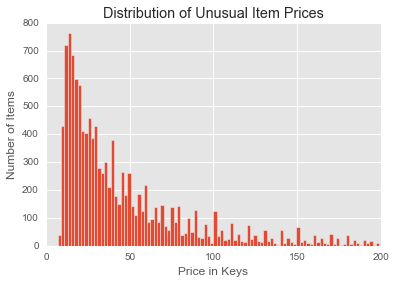

In [34]:
dfAllUnusuals = dfKeys[dfKeys['QualInt'] == 5]
dfUnusuals = dfAllUnusuals[dfAllUnusuals['Value'] < 200] # Remove obvious outliers
ax = dfUnusuals['Value'].plot(kind='hist', title='Distribution of Unusual Item Prices', bins=100)
ax.set_xlabel("Price in Keys")
ax.set_ylabel("Number of Items")

### It's obvious from this graph that unusual items rarely sell for less than 5 or 6 keys, but most of them are sold for around 10 keys. This phenomenon can be explained very simply -- in order to get an unusual, a player must actually *use a key* to open something called a crate. They have a 1.00% chance to get an unusual item in return.

### For this reason, it wouldn't make sense for unusual items to sell for anywhere close to 1 key, because all unusuals, no matter how little people like them, are rarer than keys, which can be bought from the store via microtransactions (for \$2.50)

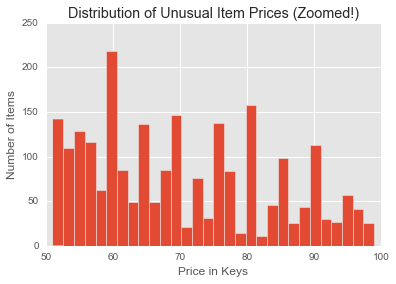

In [35]:
dfUnusuals = dfUnusuals[dfUnusuals['Value'] < 100] # Zoom
dfUnusuals = dfUnusuals[dfUnusuals['Value'] > 50] # Zooom!
ax = dfUnusuals['Value'].plot(kind='hist', title='Distribution of Unusual Item Prices (Zoomed!)', bins=30)
ax.set_xlabel("Price in Keys")
ax.set_ylabel("Number of Items")

### It's interesting to note that, because the prices are defined freely by humans (by however much people decide to sell their items for), there is a great tendency for prices to fall on or near values that are multiples of 5. For example, looking at the range 70-80 keys, there are spikes at 70 keys, 75 keys, and 80 keys.
---
### Even the smaller spikes in-between the multiples of 5 can be explained -- these are at 73.33 and 76.66 from our range defined before. 

### Why? Items on the TF2 market are often priced at values like '2.33 keys' or '1.66 refined metal' because these are more convenient to split that the obscure fractions the 'true price' usually lands on.

In [36]:
dfMetal = dfNew[dfNew['Currency'] == 'metal']

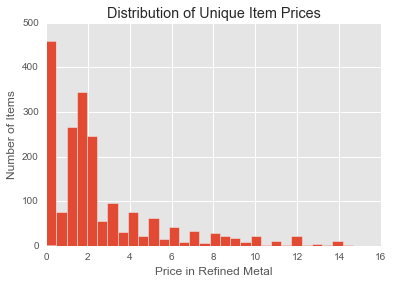

In [37]:
dfAllUniques = dfMetal[dfMetal['QualInt'] == 6]
dfUniques = dfAllUniques[dfAllUniques['Value'] < 15] # Remove obvious outliers
ax = dfUniques['Value'].plot(kind='hist', title='Distribution of Unique Item Prices', bins=30)
ax.set_xlabel("Price in Refined Metal")
ax.set_ylabel("Number of Items")

### Similar to the previous graph, we can clearly see that unique items tend to sell for easily-divisible values. However, refined metal can actually be split in-game, always into 3 parts. Therefore, prices are almost always multiples of three -- the most common price for a unique item is 0.33 refined metal, which is equivalent to a single piece of a split refined metal.
---
### It's also interesting to note here how much cheaper unique items tend to be compared to unusuals. A unique item costs, on average, 2.60 refined metal. In comparison, the average unusual item costs a whopping 1392.24 refined metal!

In [38]:
print('Average unique item metal cost: %0.2f' % (dfAllUniques['Value'].mean()))

Average unique item metal cost: 2.60


In [39]:
refinedMetalPerKey = dfAllUniques[dfAllUniques['Name'] == 'Mann Co. Supply Crate Key']['Value']
print('Average unusual item metal cost: %0.2f' % (dfAllUnusuals['Value'].mean() * refinedMetalPerKey))

Average unusual item metal cost: 1398.04


In [40]:
dfAllUnusuals['Value'].mean()

72.32465090880723

In [41]:
dfNew.head()

,Name,DefIndex,QualInt,Trade,Craft,PriceIndex,Currency,Value,Last_Update,Difference
0,Dillinger's Duffel,781,6,Tradable,Non-Craftable,0,metal,2.00,1438113663,0.230
1,Dillinger's Duffel,781,6,Tradable,Craftable,0,metal,2.00,1379254675,0.170
2,Festive Shotgun,1141,11,Tradable,Craftable,0,keys,2.50,1449871311,-1.911
3,Festive Shotgun,1141,6,Tradable,Craftable,0,metal,2.00,1452798709,-0.500
4,Carbonado Botkiller Knife Mk.I,901,11,Tradable,Craftable,0,metal,3.66,1455594472,-0.340


LinAlgError: singular matrix

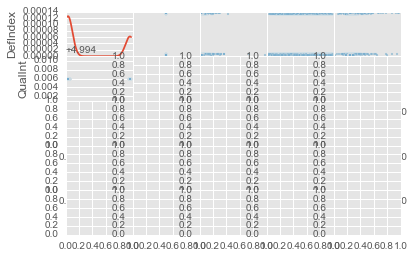

In [42]:
pd.scatter_matrix(dfAllUnusuals, diagonal='kde')

In [48]:
dfStainlessPot = dfNew[dfNew['Name'] == 'Stainless Pot']
dfStainlessPot.head(100)

,Name,DefIndex,QualInt,Trade,Craft,PriceIndex,Currency,Value,Last_Update,Difference
4525,Stainless Pot,98,1,Tradable,Craftable,0,metal,5.33,1450363255,-0.330000
4526,Stainless Pot,98,3,Tradable,Craftable,0,metal,5.00,1444582697,-0.330000
4527,Stainless Pot,98,5,Tradable,Craftable,30,keys,13.00,1450170249,-28.665000
4528,Stainless Pot,98,5,Tradable,Craftable,29,keys,22.00,1443705914,-40.137500
4529,Stainless Pot,98,5,Tradable,Craftable,60,keys,15.00,1454926722,-18.495000
4530,Stainless Pot,98,5,Tradable,Craftable,61,keys,23.00,1440512284,-40.000000
4531,Stainless Pot,98,5,Tradable,Craftable,62,keys,24.00,1434563979,-219.132500
4532,Stainless Pot,98,5,Tradable,Craftable,63,keys,39.00,1424414712,-585.003429
4533,Stainless Pot,98,5,Tradable,Craftable,64,keys,80.00,1431523316,-282.450000
4534,Stainless Pot,98,5,Tradable,Craftable,65,keys,21.00,1450908114,-122.465000


In [50]:
dfStainlessPot['QualInt'].value_counts()

5     59
6      2
14     1
3      1
1      1
Name: QualInt, dtype: int64

In [102]:
dfStainlessPot = dfNew[dfNew['Name'] == 'Stainless Pot']
dfComparison = pd.DataFrame().reindex_like(dfStainlessPot).dropna()

tempRow = dfStainlessPot[(dfStainlessPot['QualInt'] == 6) & (dfStainlessPot['Craft'] == 'Craftable')]
tempRow.is_copy = False
tempRow['Name'] = 'Normal Craftable'
dfComparison = dfComparison.append(tempRow)

tempRow = dfStainlessPot[(dfStainlessPot['QualInt'] == 6) & (dfStainlessPot['Craft'] != 'Craftable')]
tempRow.is_copy = False
tempRow['Name'] = 'Normal Uncraftable'
dfComparison = dfComparison.append(tempRow)

tempRow = dfStainlessPot[(dfStainlessPot['QualInt'] == 14)]
tempRow.is_copy = False
tempRow['Name'] = 'Collector\'s'
dfComparison = dfComparison.append(tempRow)

tempRow = dfStainlessPot[(dfStainlessPot['QualInt'] == 1)]
tempRow.is_copy = False
tempRow['Name'] = 'Genuine'
dfComparison = dfComparison.append(tempRow)

tempRow = dfStainlessPot[(dfStainlessPot['QualInt'] == 3)]
tempRow.is_copy = False
tempRow['Name'] = 'Vintage'
dfComparison = dfComparison.append(tempRow)

unusualPots = dfStainlessPot[(dfStainlessPot['QualInt'] == 5)]

dfComparison = dfComparison.drop('Currency', axis=1)
dfComparison = dfComparison.drop('PriceIndex', axis=1)
dfComparison = dfComparison.drop('Last_Update', axis=1)
dfComparison = dfComparison.drop('Difference', axis=1)

dfComparison.loc[4527] = ['Average Unusual', 98, 5, 'Tradable', 'Craftable', unusualPots['Value'].median()]

dfComparison.head(7)

,Name,DefIndex,QualInt,Trade,Craft,Value
4588,Normal Craftable,98,6,Tradable,Craftable,2.00
4587,Normal Uncraftable,98,6,Tradable,Non-Craftable,1.66
4586,Collector's,98,14,Tradable,Craftable,65.00
4525,Genuine,98,1,Tradable,Craftable,5.33
4526,Vintage,98,3,Tradable,Craftable,5.00
4527,Average Unusual,98,5,Tradable,Craftable,39.00
